<a href="https://colab.research.google.com/github/josejosepht/Point-Model-segmentation-heuristic-grasping/blob/main/point_model_segmentation_heuristic_grasping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**HW7: Point Models**
*CS5335: Jose Joseph Thandapral | Northeastern University*


---

*By defualt, the notebook is on CPU runtime.  Due to restrictions on GPU-usage, we recommend switching to GPU runtime only when you are ready to train the models, and ending the runtime session when not in use.  You can make these changes using the 'Runtime' tab on the top panel.*

---


# Utils and Imports
Run the code cells below before you start working on the rest of the notebook.

In [ ]:
%%capture
! pip install plotly scikit-learn scipy
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY" -O mug_partnet.npz && rm -rf /tmp/cookies.txt

In [ ]:
from typing import Tuple
import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

In [ ]:
def plot_pointcloud(pc, labels, preds, grasp_pose=None):
  cmap_bwr = [[0, 'rgb(0,50,255)'], [0.5, 'rgb(200,200,200)'], [1, 'rgb(255,50,0)']]
  traces = [
    go.Scatter3d(
      x=pc[..., 0].flatten() - 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=labels.flatten(),
          colorscale=cmap_bwr,
      ),
    ),
    go.Scatter3d(
      x=pc[..., 0].flatten() + 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=preds.flatten(),
          colorscale=cmap_bwr,
      ),
    )
  ]
  if grasp_pose is not None:
    gripper_lines = np.array([
      [0, 0, -0.2],
      [0, -0.3, -0.2],
      [0, -0.3, 0],
      [0, -0.5, 0],
      [0, -0.3, 0],
      [0, -0.3, 0.2],
      [0, 0, 0.2],
    ])
    gripper_lines = (grasp_pose[:3, :3] @ gripper_lines.T).T + grasp_pose[:3, 3]
    traces.append(
      go.Scatter3d(
        x=gripper_lines[:, 0] + 1,
        y=gripper_lines[:, 1],
        z=gripper_lines[:, 2],
        mode='lines',
        line=dict(width=20),
        name='grasp'
      ),
    )

  fig = go.Figure(
    data=traces,
    layout=dict(
      scene=dict(
        xaxis=dict(range=[-2.1, 2.1]),
        yaxis=dict(range=[-1.1, 1.1]),
        zaxis=dict(range=[-1.1, 1.1]),
        aspectmode='manual',
        aspectratio=dict(x=4, y=2, z=2),
        camera=dict(
          up=dict(x=0, y=0, z=1),
          center=dict(x=0, y=0, z=0),
          eye=dict(x=0, y=-5, z=5),
          projection=dict(type='orthographic'),
        ),
      ),
      width=1000,
      height=500,
      margin=dict(l=0, r=0, t=0, b=0),
      plot_bgcolor="rgba(0,0,0,0)",
      paper_bgcolor="rgba(0,0,0,0)",
    )
  )
  fig.show()

def q1a_checker(tnet: nn.Module):
  num_params = sum(p.numel() for p in tnet(3).parameters() if p.requires_grad)
  assert num_params == 799113, (
      f'Incorrect number of parameters. Expected 799113, found {num_params}.'
  )

  x = torch.randn((1, 3, 127))
  out = tnet(k=3)(x)
  assert out.shape == (1, 3, 3), (
      f'Incorrect output shape. Expected (3, 3), found {out.shape[1:]}.'
  )

  x = torch.randn((1, 64, 317))
  out = tnet(k=64)(x)
  assert out.shape == (1, 64, 64), (
      f'Incorrect output shape. Expected (64, 64), found {out.shape[1:]}.'
  )
  print('Q1a: PASSED')


def q1b_checker(pnet: nn.Module):
  net = pnet()

  num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  assert num_params == 2801481, (
      f'Incorrect number of parameters. Expected 2801481, found {num_params}.'
  )

  net = pnet()
  x = torch.randn((1, 3, 163))
  gfeat, lfeat, _, _ = net(x)
  assert gfeat.shape == (1, 1024), (
      f'Incorrect global feature shape. Expected (1024, ), found {gfeat.shape[1:]}.'
  )

  assert lfeat.shape == (1, 64, 163), (
      f'Incorrect local feature shape. Expected (64, 163), found {lfeat.shape[1:]}.'
  )

  x_shuffled = x[:, :, torch.randperm(163)]
  gfeat_shuffled, lfeat_shuffled, _, _ = net(x_shuffled)
  assert torch.allclose(gfeat, gfeat_shuffled), (
      f'Incorrect implementation, expected global features to be invariant to point ordering.'
  )

  print('Q1b: PASSED')

# 1. Implementing [PointNet](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf)

---


The TNet module and PointNetBackbone module have been implemented below. The TNet module implements the transformation network, and the PointNetBackbone module implements the backbone of PointNet, including all the operations shown in the image provided. ReLUs have been placed between each linear operation in the MLPs. The implementation also includes the necessary parameters as specified in the docstrings of the respective modules. Additionally, there are checker functions available to verify the correctness of the implementation.

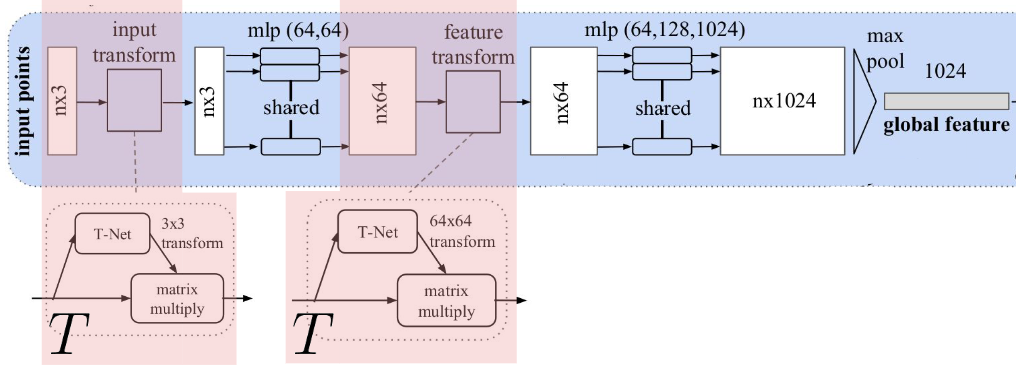


*Point clouds are non-ordered collections of cartesian co-ordinate information with or without rgb color values. There would not inherently be any ordering information or correspondences. Specifically, any order would serve no purpose for a point cloud and they would have to be displayed as a whole for any context.
PointNet's invariance to the order of points is owed to it's utilization of symmetric functions to aggregate local features from individual points within a point cloud. PointNet uses max pooling and multi-layer perceptrons (MLPs) to learn global feature representations from local features, and these operations are permutation-invariant, meaning they produce the same output regardless of the order of the input points. Also, fully connected layers with shared weights are used to learn global feature representations that are agnostic to the order of the input points, as the same weights are applied to all points regardless of their order.*



In [ ]:
class TNet(nn.Module):
  def __init__(self, k: int):
    '''Module that predicts a k-by-k transformation matrix

    The layers are described below.  Please follow this description, even though
    it differs slightly from what was presented in lecture.  Do not use batchnorms
    anywhere in this module:

    1. SharedMLP: three linear layers with output dimensions of 64, 128, and 1024,
                  respectively.  Include relu's after each linear operation
    2. Max pool operation over all points (dim=1)
    3. Flatten operation to generate tensor of shape (batch_size, 1024)
    4. MLP: three linear layers with output dimensions of 512, 256, and k*k, respectively.
            Include ReLU's *between* the layers (NOT ON OUTPUT!)
    5. Reshape operation to produce tensor of shape (batch_size, k, k)

    '''
    super().__init__()
    self.k = k
    self.linear1 = nn.Conv1d(in_channels=k,out_channels=64, kernel_size=1)
    self.linear2 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1)
    self.linear3 = nn.Conv1d(in_channels=128,out_channels=1024,kernel_size=1)
    self.relu = nn.ReLU(inplace=True)
    self.flatten = nn.Flatten(start_dim=1,end_dim=2)
    self.linear4 = nn.Linear(in_features=1024,out_features=512)
    self.linear5 = nn.Linear(in_features=512,out_features=256)
    self.linear6 = nn.Linear(in_features=256,out_features=k*k)


  def forward(self, x: Tensor):
    '''Performs forward pass

    Arguments
    ---------
    x : tensor of shape (B, 3, N) where B is batch size
        and N is the number of points

    Returns
    -------
    tensor of shape (B, self.k, self.k)
    '''
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    x = self.linear3(x)
    x = self.relu(x)
    x = torch.max(x,dim=2,keepdim=True)[0]
    x = self.flatten(x)
    x = self.linear4(x)
    x = self.relu(x)
    x = self.linear5(x)
    x = self.relu(x)
    x = self.linear6(x)
    x = self.relu(x)
    x = x.reshape(-1, self.k, self.k)
    return x


class PointNetBackbone(nn.Module):
  def __init__(self):
    '''PointNet network without predictions head, see picture for more information.

    USE ReLU BETWEEN ALL LINEAR LAYERS IN MLP!! For instance, "mlp(64,64)"
    corresponds to two linear operations with output dimensions of 64 and 64,
    with a ReLU between them
    '''
    super().__init__()
    self.tnet1 = TNet(k=3)
    self.linear1 = nn.Conv1d(in_channels=3,out_channels=64,kernel_size=1)
    self.linear2 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=1)
    self.tnet2 = TNet(k=64)
    self.linear3 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=1)
    self.linear4 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=1)
    self.linear5 = nn.Conv1d(in_channels=128,out_channels=1024,kernel_size=1)
    self.relu = nn.ReLU(inplace=True)


  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    '''Perform forward pass, returning additional intermediate features which are
    needed for subsequent processing or computing loss terms

    Arguments
    ---------
    x : point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    global_feature: float tensor of shape (B, 1024) generated by max pool operation
    point_features: float tensor of shape (B, 64, N), features produced by feature
                    transform operation
    input_transform: float tensor of shape (B, 3, 3); input transformation matrix
                     produced by first TNet module
    feature_transform: float tensor of shape (B, 64, 64); feature transformation matrix
                     produced by second TNet module
    '''
    T1 = self.tnet1(x)
    x = torch.matmul(T1,x)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    T2 = self.tnet2(x)
    x = torch.matmul(T2,x)
    point_features = x
    x = self.linear3(x)
    x = self.relu(x)
    x = self.linear4(x)
    x = self.relu(x)
    x = self.linear5(x)
    x = self.relu(x)
    x = torch.max(x,dim=2)[0]
    global_feature = x

    return global_feature, point_features, T1, T2


q1a_checker(TNet)
q1b_checker(PointNetBackbone)

Q1a: PASSED
Q1b: PASSED


# 2. PointNet for Segmentation
Here, we implement a PointNet model for point cloud segmentation, implement auxilliary loss functions and then train it to segment coffee mug handles. For instance, given a point cloud of a coffee mug, we want the network to predict which points belong to the handle.

The PointNetSeg module is implemented below.  This network broadcasts the global feature vector to all point-wise features then performs additional point-wise processing.
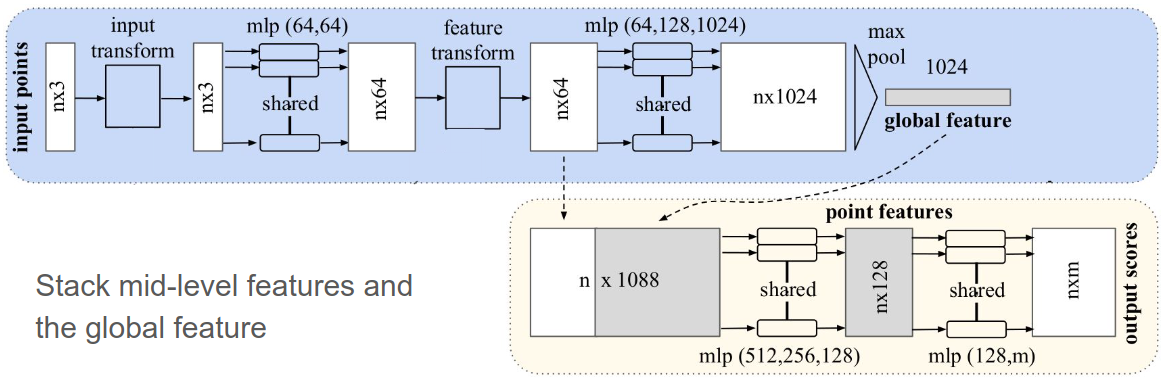

The `compute_losses` method applies a cross entropy loss to predict better class scores and a regularization loss to push the learned transformation matrices to be orthogonal.

Here, the point cloud is transformed so its center of mass is zero and the maximum magnitude is 1,i.e, we center and normalize the point cloud in this way before passing it as input to the network.  Consider how this changes the networks ability to generalize.

*Centering and normalizing the point cloud as a preprocessing step can enhance the network's generalization ability by achieving translation and scale invariance, and reducing the impact of outliers or noise. It allows the network to process the point cloud relative to a consistent reference point and scale, making it more robust to varying translations, scales, and levels of noise in the input data. Additionally, this preprocessing step can simplify the learning process by providing a standardized input representation, potentially leading to improved performance and robust results.*

The code cell is run to train the network for 20 epochs then plot the predictions.

*We see that there is a bit of loss of information as compared to the original point cloud with potentially more points. This reduction in point cloud size may impact the network's ability to capture fine-grained details or subtle features present in the original point cloud, as some points may be omitted from the subset. But it still differentiates into the handle and mug-body classes quite well.*  

In [ ]:
class PointNetSeg(nn.Module):
  def __init__(self, num_classes: int):
    '''PointNet model with dense output that predicts per-pixel class labels

    The PointNetBackbone is used in the following manner: First, the global
    feature is broadcasted to every point. Then, the global features and point
    features are concatenated to create a tensor of shape (B, 1088, N). Finally,
    a shared MLP is employed to generate the output scores, resulting in a
    tensor of shape (B, num_classes, N).
    '''
    super().__init__()
    self.backbone = PointNetBackbone()
    self.linear1 = nn.Conv1d(in_channels=1088,out_channels=512,kernel_size=1)
    self.linear2 = nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1)
    self.linear3 = nn.Conv1d(in_channels=256,out_channels=128,kernel_size=1)
    self.linear4 = nn.Conv1d(in_channels=128,out_channels=128,kernel_size=1)
    self.linear5 = nn.Conv1d(in_channels=128,out_channels=num_classes,kernel_size=1)

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    '''Perform forward pass

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    tuple:
      output_scores: float tensor of per-point logits; shape (B, num_classes, N)
      input_transform: float tensor of shape (3, 3); provided by PointNetBackbone.forward
      feature_transform: float tensor of shape (64, 64); provided by PointNetBackbone.forward
    '''
    global_feature, point_features, T1, T2 = self.backbone(x)

    n = point_features.shape[2]

    global_feature = global_feature.view(-1, 1024, 1).repeat(1, 1, n)

    x = torch.cat([point_features,global_feature],dim=1)

    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.linear5(x)

    output_scores = x

    return output_scores, T1, T2

  @torch.no_grad()
  def predict(self, x: Tensor):
    '''Predict class labels for each point in point cloud

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    per-point class labels, long tensor of shape (B, N)
    '''
    out = self.forward(x)[0]
    return torch.argmax(out, dim=1)

  def compute_losses(self, x: Tensor, labels: Tensor) -> Tuple[Tensor, Tensor]:
    '''Compute losses

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)
    labels: per-point class labels, long tensor of shape (B, N)

    Returns
    -------
    tuple:
      cls_loss: classification loss generated by `nn.CrossEntropy()(output_scores, labels)`
      ortho_loss: regularization loss that penalizes transformation matrices that are not orthogonal.
                  It is computed as $$L = \|I - AA^T\|^2_F$$. In other words, take the frobenius norm
                  of an Identity matrix minus the outer product of the transformation matrix.  Return the
                  sum of the loss computed for the input_transform matrix and the feature_transform matrix.
                  Hint: use `torch.linalg.matrix_norm` to compute frobenius norm
    '''
    scores, tfm3x3, tfm64x64 = self.forward(x)
    cls_loss = nn.CrossEntropyLoss()(scores, labels)

     # Compute ortho loss for input_transform matrix
    input_transform_ortho_loss = torch.linalg.matrix_norm(torch.eye(3) - torch.matmul(tfm3x3, tfm3x3.transpose(1,2)), ord='fro')**2

    # Compute ortho loss for feature_transform matrix
    feature_transform_ortho_loss = torch.linalg.matrix_norm(torch.eye(64) - torch.matmul(tfm64x64, tfm64x64.transpose(1,2)), ord='fro')**2

    # Compute total ortho loss
    ortho_loss = input_transform_ortho_loss + feature_transform_ortho_loss

    cls_loss = torch.mean(cls_loss)
    ortho_loss = torch.mean(ortho_loss)

    return cls_loss,ortho_loss


In [ ]:
class PointCloudDataset(Dataset):
  def __init__(self, path, pc_size: int = 1024):
    '''Dataset including point clouds with labeled per-point classes

    Each point cloud has 2048 points, but they are randomly downsampled to
    `pc_size` when accessed by data loader
    '''
    data = np.load(path, allow_pickle=True)
    self.pcs = data['pc']
    self.segs = data['seg']

    self.pc_size = pc_size

  def __getitem__(self, idx: int):
    '''Retrieve point cloud with segmentation labels, point clouds are centered
    at (0,0,0) and normalized such that all points lie within the unit sphere

    Returns
    -------
    pc : float tensor of shape (3, pc_size), point cloud
    seg : long tensor of shape (pc_size, ), segmentation labels
    '''
    pc = self.pcs[idx]
    seg = self.segs[idx]

    # take random subset of full pointcloud
    indices = np.arange(len(pc))
    np.random.shuffle(indices)
    indices = indices[:self.pc_size]
    pc = pc[indices]
    seg = seg[indices]

    # add gaussian noise
    pc += 0.02 * np.random.random(size=pc.shape)

    # randomly rotate about z-axis
    theta = np.random.uniform(0, 2*np.pi)
    rot_mtx = np.array((
        (np.cos(theta), -np.sin(theta), 0),
        (np.sin(theta), np.cos(theta), 0),
        (0, 0, 1),
    ))
    pc = np.einsum('ni,ji->nj', pc, rot_mtx)

    # center and normalize point cloud
    pc = pc - pc.mean(axis=0)
    pc /= np.linalg.norm(pc, axis=1, keepdims=True).max(axis=0, keepdims=True)

    # convert to tensors
    pc = torch.from_numpy(pc.T).float()
    seg = torch.from_numpy(seg.T).long()

    return pc, seg

  def __len__(self):
    return self.pcs.shape[0]

In [ ]:
# This code cell trains the network
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(
    PointCloudDataset('mug_partnet.npz', pc_size=1024),
    lengths=[0.8, 0.2],
    generator=generator,
)
train_dl = DataLoader(train_set, batch_size=12, shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=12, shuffle=False, num_workers=2)

model = PointNetSeg(num_classes=2)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

# parameter balancing two loss terms
gamma = 0.05

num_epochs = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch_id in range(num_epochs):
  train_losses = []
  model.train()
  for pc, lbl in train_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    cls_loss, ortho_loss = model.compute_losses(pc, lbl)
    loss = cls_loss + gamma * ortho_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  test_losses = []
  model.eval()
  for pc, lbl in test_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    with torch.no_grad():
      cls_loss, ortho_loss = model.compute_losses(pc, lbl)
      loss = cls_loss + gamma * ortho_loss

    test_losses.append(loss.item())

  train_loss = np.mean(train_losses)
  test_loss = np.mean(test_losses)

  print(f'Epoch={epoch_id} | Train loss={train_loss:.4f} | Test loss={test_loss:.4f}')

Epoch=0 | Train loss=2.8221 | Test loss=2.0477
Epoch=1 | Train loss=1.7391 | Test loss=1.4930
Epoch=2 | Train loss=1.2307 | Test loss=0.9206
Epoch=3 | Train loss=0.6378 | Test loss=0.4354
Epoch=4 | Train loss=0.3895 | Test loss=0.3924
Epoch=5 | Train loss=0.3731 | Test loss=0.3862
Epoch=6 | Train loss=0.3680 | Test loss=0.3836
Epoch=7 | Train loss=0.3651 | Test loss=0.3691
Epoch=8 | Train loss=0.3533 | Test loss=0.3472
Epoch=9 | Train loss=0.3334 | Test loss=0.3303
Epoch=10 | Train loss=0.3148 | Test loss=0.2924
Epoch=11 | Train loss=0.2930 | Test loss=0.3150
Epoch=12 | Train loss=0.2949 | Test loss=0.2799
Epoch=13 | Train loss=0.2897 | Test loss=0.2937
Epoch=14 | Train loss=0.2714 | Test loss=0.2963
Epoch=15 | Train loss=0.2732 | Test loss=0.2850
Epoch=16 | Train loss=0.2848 | Test loss=0.2526
Epoch=17 | Train loss=0.2666 | Test loss=0.2655
Epoch=18 | Train loss=0.2580 | Test loss=0.2581
Epoch=19 | Train loss=0.2656 | Test loss=0.2635


In [ ]:
# plot predictions from test set
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]

## PC Downsampling (can be commented to see alternate results)
subset_size = 512
subset_ind = np.random.choice(np.arange(pc.shape[-1]), size=subset_size, replace=False)
pc = pc[:, subset_ind]
lbl = lbl[subset_ind]

pc = pc.unsqueeze(0).to(device)
with torch.no_grad():
  pred = torch.softmax(model.forward(pc)[0], dim=1)[:, 1]

plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T
)

# 3. Heuristic Grasping using Segmentation Output

In the code cell below, a heuristic is applied to generate a grasp pose that grasps the mug specifically by its handle. By running the code cells, you can visualize the grasp predictions for two scenarios: when the mug is upright and when the mug is on its side.

*The predictions would be good for the upright mug.  The given heuristic grasp pose generator based on PCA may not produce accurate grasp poses when the mug is not upright because it relies on assumptions about the alignment of the mug handle with the principal axes, which may not hold true in all orientations. Hence, the PCA based heuristic may given incorrect grasp predictions*


*A possible heuristic for generating grasps along the rim of a mug, regardless of its pose, could involve using a cylinder fitting algorithm, such as RANSAC. This would involve extracting points on the rim of the mug from the point cloud, applying the cylinder fitting algorithm to estimate the parameters of the fitted cylinder, including its center, axis, and radius. These parameters can then be used to generate grasp poses that align with the cylinder's axis and are located at the rim of the mug.*



In [ ]:
def estimate_handle_grasp(pc, handle_mask):
  '''Heuristic grasp pose generator.  Performs PCA on all points
  that are predicted to belong to mug handle and aligns gripper to
  component axes

  pc: float ndarray of shape (N, 3)
  mask: boolean ndarray (N,)

  returns: 4x4 ndarray, valid transformation matrix
  '''
  handle_pc = pc[handle_mask]
  pca = PCA(n_components=3)
  pca.fit(handle_pc)

  pose = np.eye(4)
  pose[:3, 3] = handle_pc.mean(axis=0)
  pose[:3, :3] = pca.components_.T
  return pose

In [ ]:
# UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

pred = model.predict(pc)
pose = estimate_handle_grasp(pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

In [ ]:
# NON-UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

tfm_pc = torch.einsum(
  'bin,ji->bjn', pc, torch.from_numpy(Rotation.random().as_matrix()).float(),
)
pred = model.predict(tfm_pc)
pose = estimate_handle_grasp(tfm_pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    tfm_pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

# Footnote

*PointNet++ works better at detecting features at multiple scales as it uses a a set of nested PointNet modules to process points at different levels of detail, allowing it to capture both local and global contextual information. The local region proposal network (RPN) used in PointNet++ groups nearby points and form local regions, which are then processed by the PointNet modules. Hence there is increased local point context and it adds to the accuracy in segmentation. Further, the input point cloud is selectively sampled using adaptive sampling strategies in PointNet++. Hence more computational resources are allocated to prominent feature points and is not wasted on lesser important points.
The major downside of PointNet++ is the higher complexity of implementation than PointNet. Further more training data is required in PointNet++ in addition to higher storage requirements.*
